# Integer Partitions

## Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv("../../data/partition.csv", comment='#', converters={"rates": lambda x: np.fromstring(x[1:-1], dtype=int, sep=' ')})

## Prepare `DataFrame`

add statistics to `df`

In [4]:
df['n'] = df['rates'].apply(len)

In [5]:
df['h'] = df['rates'].apply(np.sum)

In [6]:
df['cycle-end'] = df['cycle-start'] + df['cycle-length']

In [7]:
df['norm_backlog'] = df['backlog'] / df['h']

In [8]:
df['norm_rates'] = df['rates'] / df['h']

In [9]:
df['std'] = df['norm_rates'].apply(np.std)

In [10]:
df['min'] = df['norm_rates'].apply(np.min)

In [11]:
df['max'] = df['norm_rates'].apply(np.max)

In [12]:
df['nunique'] = df['norm_rates'].apply(lambda x: len(np.unique(x)))

In [13]:
df['norm_rates_str'] = df['norm_rates'].astype("string")

In [14]:
df['diff-backlog'] = df.groupby(by='norm_rates_str', group_keys=False)['norm_backlog'].apply(lambda x: x - x.min())

In [15]:
df['diff-cycle-start'] = df.groupby(by='norm_rates_str', group_keys=False)['cycle-start'].apply(lambda x: x - x.min())

In [16]:
df['diff-cycle-length'] = df.groupby(by='norm_rates_str', group_keys=False)['cycle-length'].apply(lambda x: x - x.min())

In [17]:
df['best-backlog'] = df['diff-backlog'] == 0

create `df_dr` with **d**uplicates and trivial instance **r**emoved

In [18]:
df_dr = df[(~df.duplicated(['strategy', 'norm_rates_str'])) & (df['n']>1)]

## Statistics About Setup

get tuple with number of instances before removing duplicates and trivial instances, number of duplicates and trivial instances, and remaining number of instances

In [19]:
a = len(df[df['strategy'] == 'RM'])
b = len(df_dr[df_dr['strategy'] == 'RM'])
a, a-b, b

(81155, 1449, 79706)

distribution of generated instances by value of (1) `H` (before removing duplicates), (2) number of cips `n` (after removing duplicates), and (3) number of unique fill rates `nunique` (after removing duplicates)

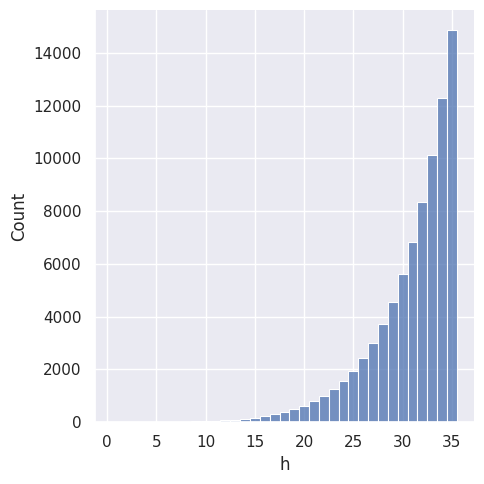

In [20]:
sns.displot(data=df[df['strategy'] == 'RM'], x='h', discrete=True)

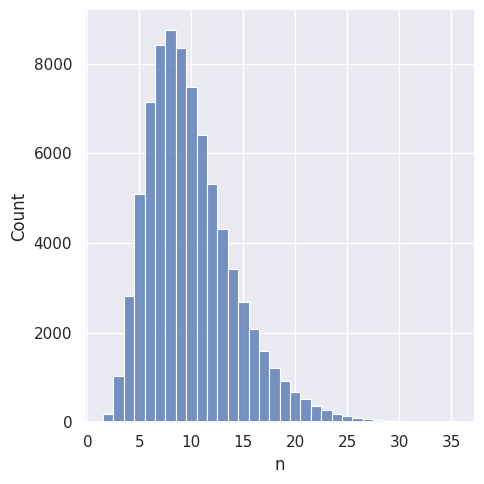

In [21]:
sns.displot(data=df_dr[df_dr['strategy'] == 'RM'], x='n', discrete=True)

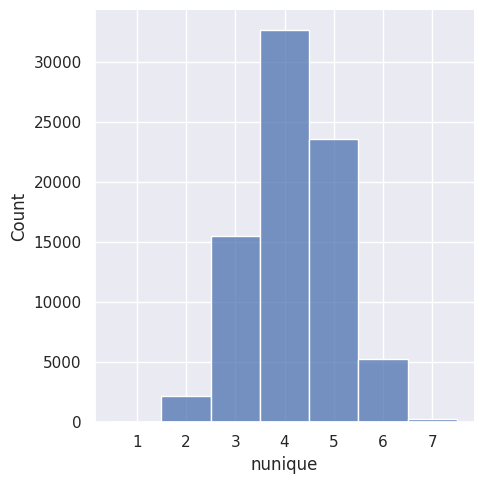

In [22]:
sns.displot(data=df_dr[df_dr['strategy'] == 'RM'], x='nunique', discrete=True)

## Distribution of Backlog

histogram of backlog for every strategy, bins start at 1, width 0.05

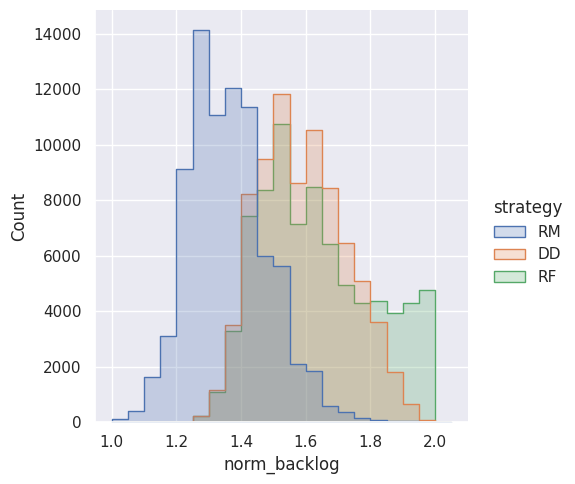

In [23]:
bins = np.arange(22) / 20 + 1
sns.displot(data=df_dr, x='norm_backlog', hue='strategy', element='step', bins=bins)

eCDF of backlog for every strategy

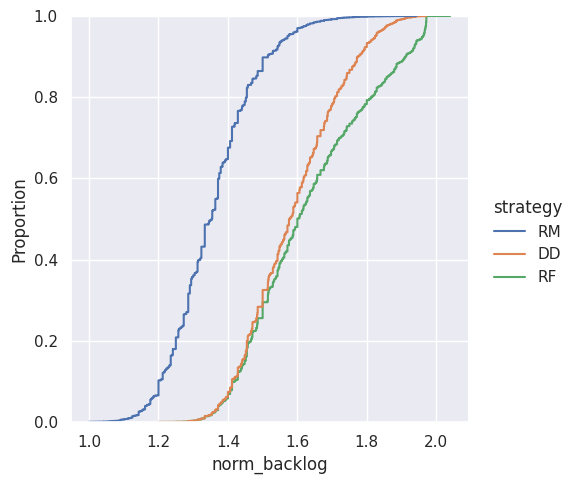

In [24]:
sns.displot(data=df_dr, x='norm_backlog', hue='strategy', kind='ecdf')

mean backlog for every strategy

In [25]:
df_dr.groupby('strategy')['norm_backlog'].mean()

strategy
DD    1.587224
RF    1.632851
RM    1.356023
Name: norm_backlog, dtype: float64

percentage of instances where `Reduce-Max` is not the best of the 3 strategies

In [26]:
len(df_dr[(df_dr['strategy'] == 'RM') & (df_dr['diff-backlog'] != 0)]) / len(df_dr[df_dr['strategy'] == 'RM'])

0.04304569292148646

proportions for how many instances achieve (1) the same backlog for DD and RF, (2) a smaller backlog with DD, (3) a smaller backlog with RF

In [27]:
dd_df = df_dr[df_dr['strategy'] == 'DD']['norm_backlog'].reset_index(drop=True)
rf_df = df_dr[df_dr['strategy'] == 'RF']['norm_backlog'].reset_index(drop=True)
equal, ddbest, rfbest = [x.sum() for x in [dd_df == rf_df, dd_df < rf_df, dd_df > rf_df]]
total = equal + ddbest + rfbest
[x / total for x in [equal, ddbest, rfbest]]

[0.6692218904473942, 0.32796778159737033, 0.0028103279552354906]

eCDF of the difference between a strategy's backlog compared to the smallest backlog for this instance (`diff-backlog`)

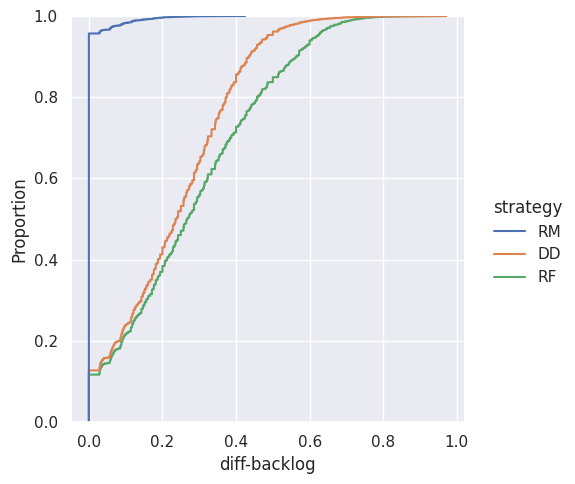

In [28]:
sns.displot(data=df_dr, x='diff-backlog', hue='strategy', kind='ecdf')

violin plot showing a kernel density estimation (KDE) for each strategy's backlog, split by whether the strategy achieves the lowest backlog for an instance

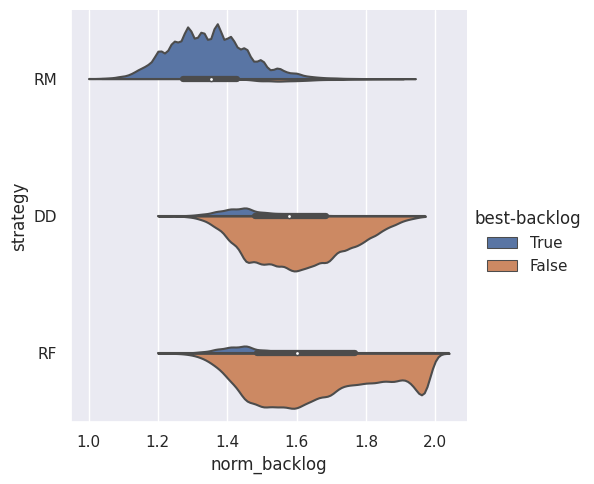

In [29]:
sns.catplot(data=df_dr, x='norm_backlog', y='strategy', hue='best-backlog', hue_order=[True, False], kind='violin', split=True, cut=0, scale='count')

## Backlog by Number of Cups

line plot showing the (1) maximum backlog and (2) mean backlog for instances grouped by `n`

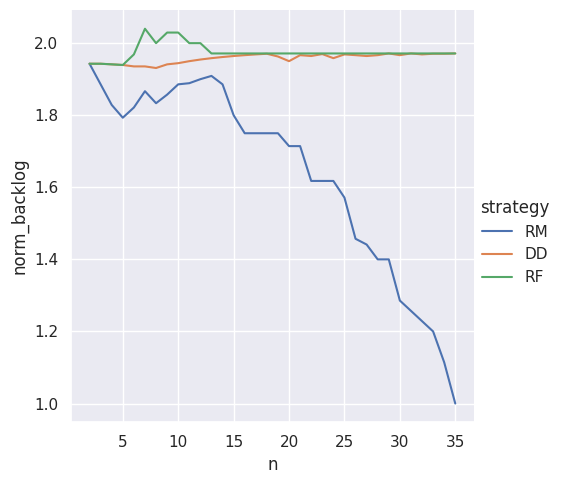

In [30]:
sns.relplot(data=df_dr.groupby(['n', 'strategy'], sort=False).agg({'norm_backlog': 'max'}), x='n', y='norm_backlog', hue='strategy', kind='line')

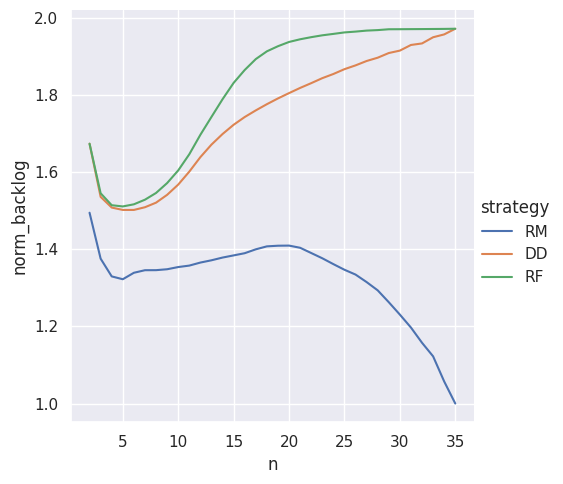

In [31]:
sns.relplot(data=df_dr.groupby(['n', 'strategy'], sort=False).agg({'norm_backlog': 'mean'}), x='n', y='norm_backlog', hue='strategy', kind='line')

list of instances with backlog greater than 2

In [32]:
df_dr[df_dr['norm_backlog'] > 2]

,strategy,backlog,cycle-start,cycle-length,rates,n,h,cycle-end,norm_backlog,norm_rates,std,min,max,nunique,norm_rates_str,diff-backlog,diff-cycle-start,diff-cycle-length,best-backlog
27758,RF,51,28,10,"[5, 5, 3, 3, 3, 3, 3]",7,25,38,2.040000,"[0.2, 0.2, 0.12, 0.12, 0.12, 0.12, 0.12]",0.036140,0.120000,0.200000,2,[0.2 0.2 0.12 0.12 0.12 0.12 0.12],0.840000,14,0,False
198159,RF,69,39,14,"[5, 5, 3, 3, 3, 3, 3, 3, 3, 3]",10,34,53,2.029412,"[0.14705882352941177, 0.14705882352941177, 0.0...",0.023529,0.088235,0.147059,2,[0.14705882 0.14705882 0.08823529 0.08823529 0...,0.794118,15,0,False
198171,RF,69,39,72,"[6, 5, 5, 3, 3, 3, 3, 3, 3]",9,34,111,2.029412,"[0.17647058823529413, 0.14705882352941177, 0.1...",0.033327,0.088235,0.176471,3,[0.17647059 0.14705882 0.14705882 0.08823529 0...,0.794118,15,50,False


number of instances that have less than 3 or more than 25 cups (in percent)

In [33]:
len(df_dr[(df_dr['n'] < 3) | (df_dr['n'] > 25)]) / len(df_dr)

0.005971946904875417

letter-value plot showing backlog categorized by (1) the number of cups and (2) the number of unique fill rates

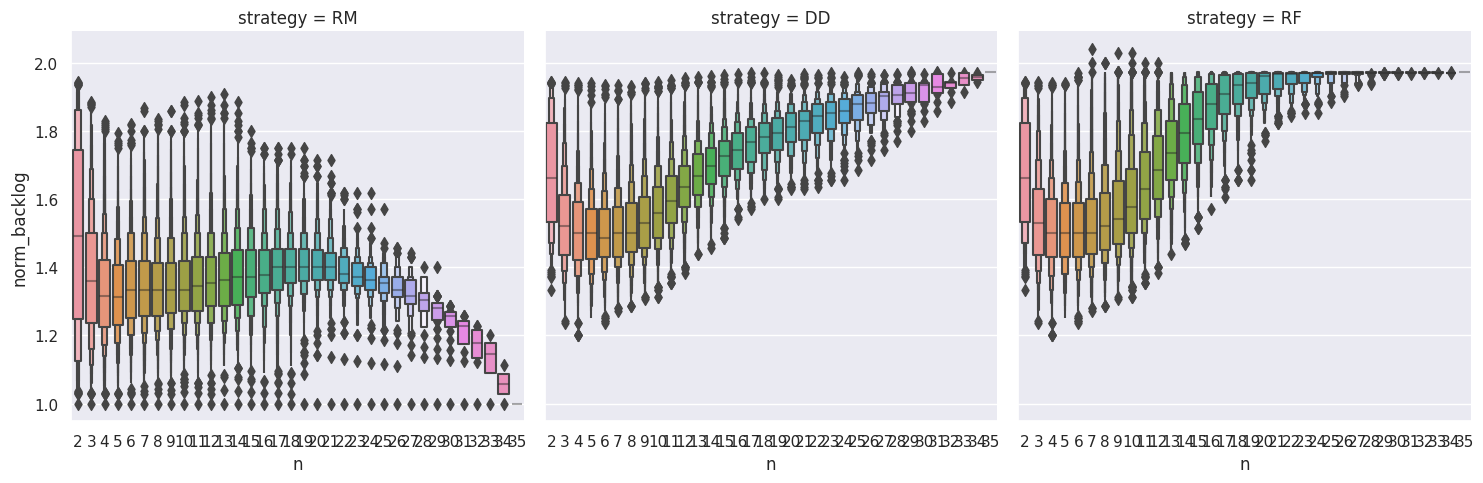

In [34]:
sns.catplot(data=df_dr, x='n', y='norm_backlog', col='strategy', kind='boxen')

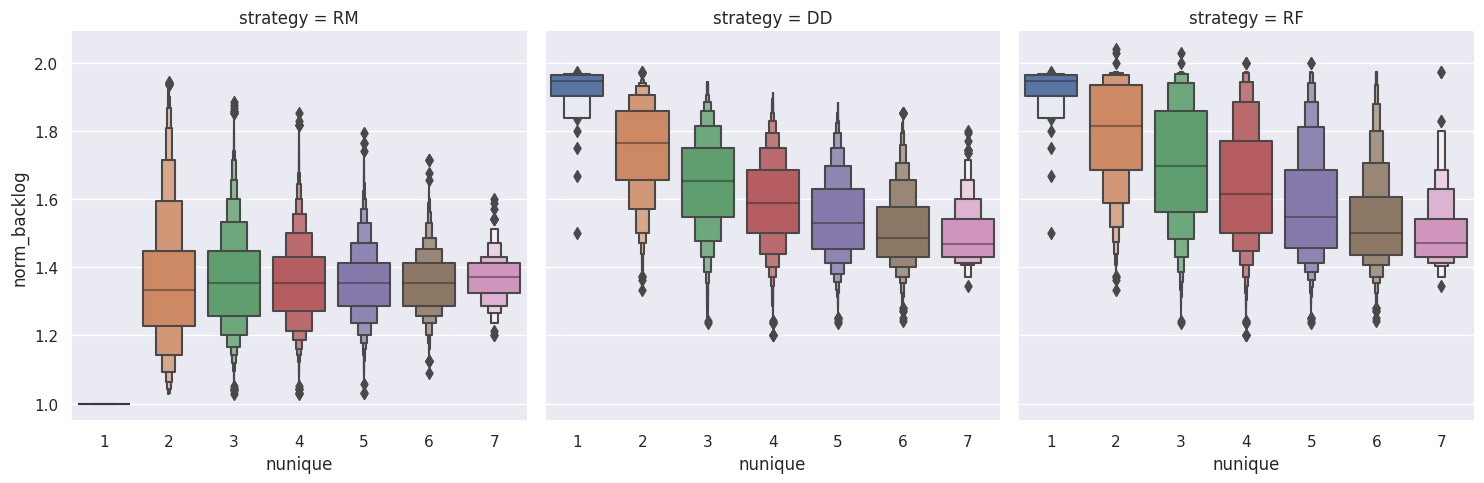

In [35]:
sns.catplot(data=df_dr, x='nunique', y='norm_backlog', col='strategy', kind='boxen')

## Effect of Min/Max Fill Rates on Backlog

letter-value plot of backlog categorized by rounded (1) min fill rates and (2) max fill rates

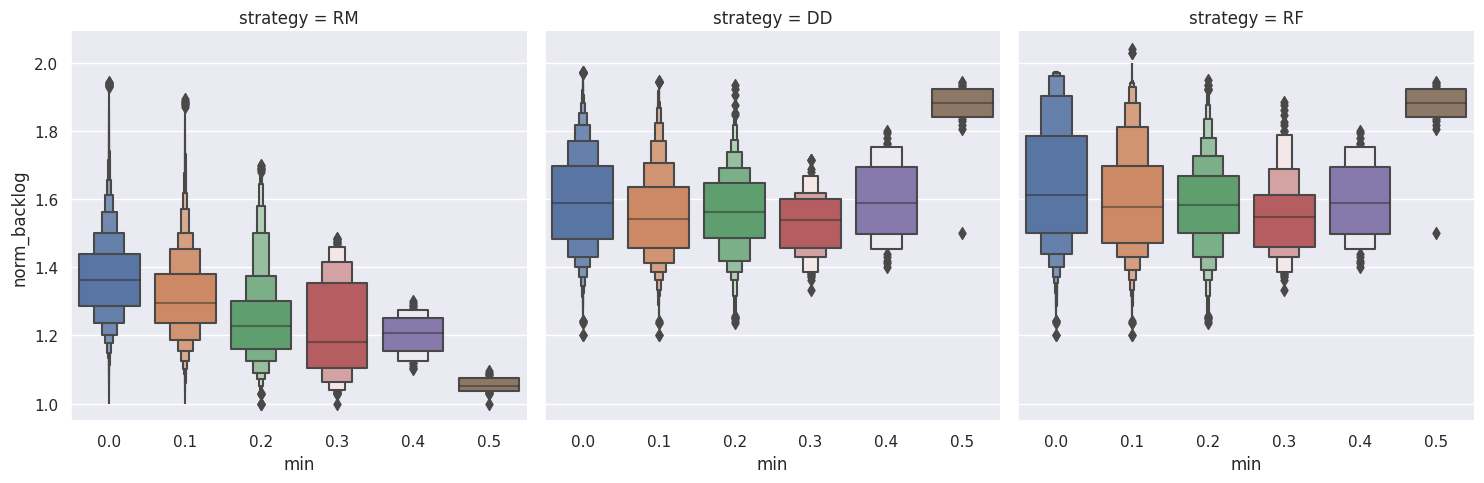

In [36]:
sns.catplot(df_dr.round({'min': 1}), x='min', y='norm_backlog', col='strategy', kind='boxen')

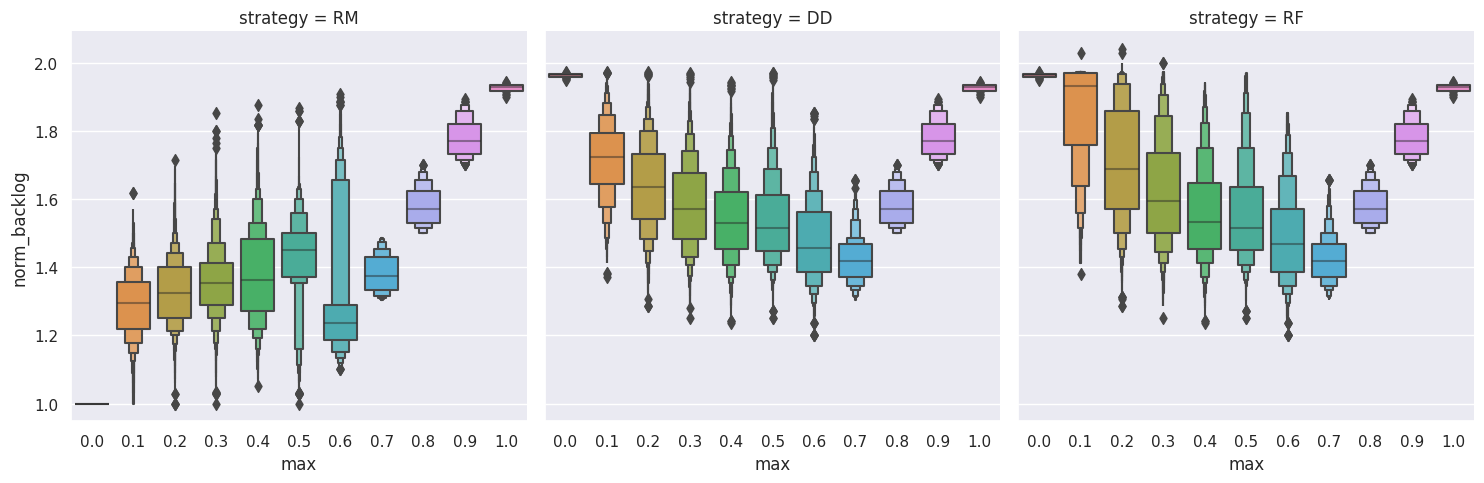

In [37]:
sns.catplot(df_dr.round({'max': 1}), x='max', y='norm_backlog', col='strategy', kind='boxen')

verification that every instance has the same backlog for every strategy, if the maximum rate is greater than 0.736

In [38]:
len(df_dr[(df_dr['max'] > 0.736) & (df_dr['best-backlog'] == False)]) == 0

True

verification that every instance with a maximum rate greater than 0.736 has a backlog equal to twice the maximum fill rate
(checking for > 1e-9 because of rounding errors for floats)

In [39]:
len(df_dr[(df_dr['max'] > 0.736) & ((df_dr['norm_backlog'] - 2*df_dr['max']).abs() > 1e-9)]) == 0

True

scatter plot of backlog by min and max fill rates, with the color of a marker indicating the backlog

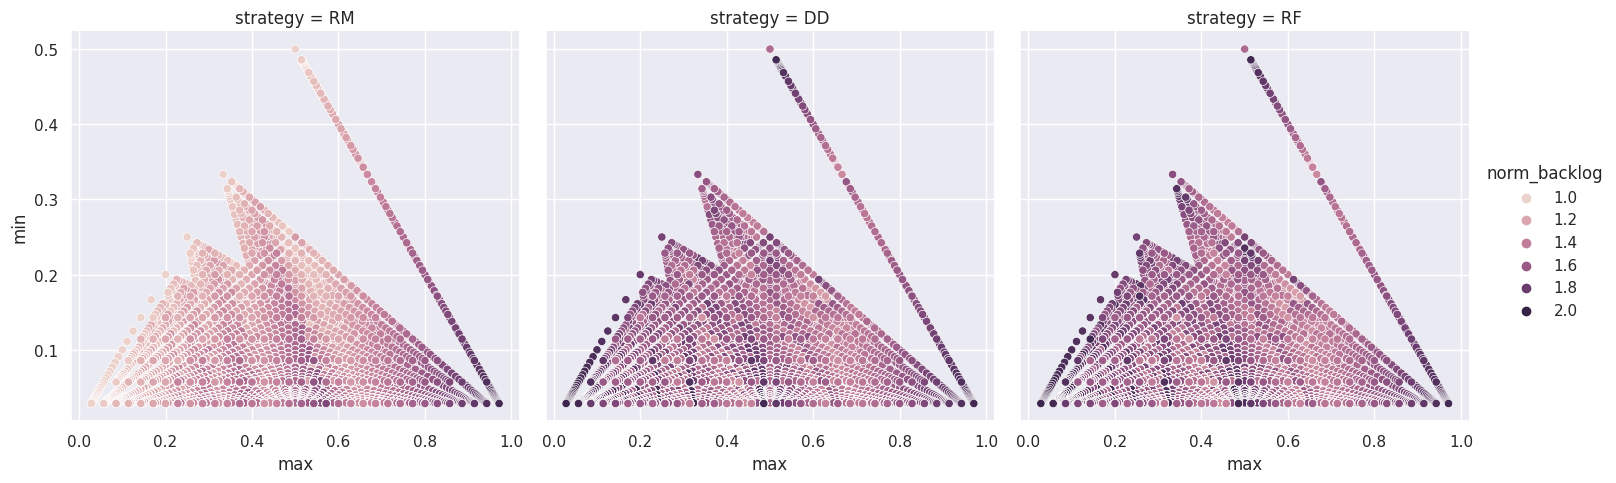

In [40]:
sns.relplot(df_dr, x='max', y='min', hue='norm_backlog', col='strategy')

pivot table for heatmaps (rounded fill rates to reduce number of tiles)

In [41]:
pt_max = df_dr.round({'max': 2}).pivot_table(index=['strategy', 'max'], columns='nunique', values='norm_backlog', aggfunc=np.max).iloc[::-1]
pt_mean = df_dr.round({'max': 2}).pivot_table(index=['strategy', 'max'], columns='nunique', values='norm_backlog', aggfunc=np.mean).iloc[::-1]

common colorbar values for heatmaps

In [42]:
vmin = min(np.nanmin(pt_max.values), np.nanmin(pt_mean.values))
vmax = max(np.nanmax(pt_max.values), np.nanmax(pt_mean.values))

heatmap showing max backlog for (1) RM and (2) DD, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

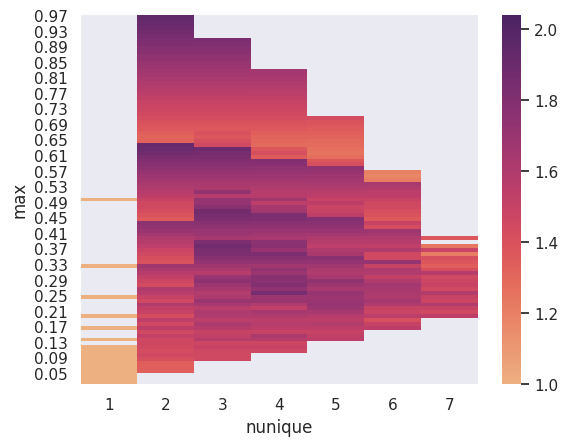

In [43]:
sns.heatmap(pt_max.loc['RM'], cmap='flare', vmin=vmin, vmax=vmax)

<AxesSubplot: xlabel='nunique', ylabel='max'>

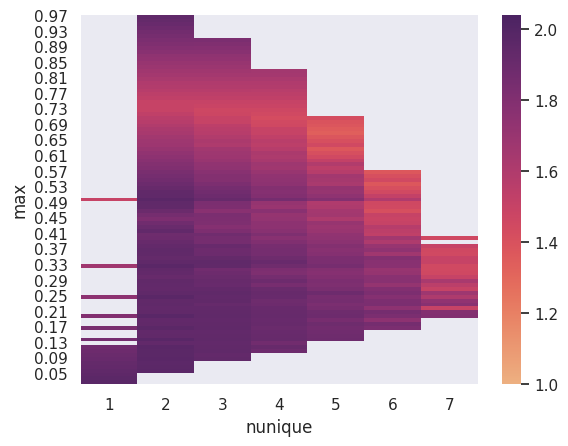

In [44]:
sns.heatmap(pt_max.loc['DD'], cmap='flare', vmin=vmin, vmax=vmax)

heatmap showing mean backlog for (1) RM and (2) DD, depending on max fill rate and number of unique fill rates

<AxesSubplot: xlabel='nunique', ylabel='max'>

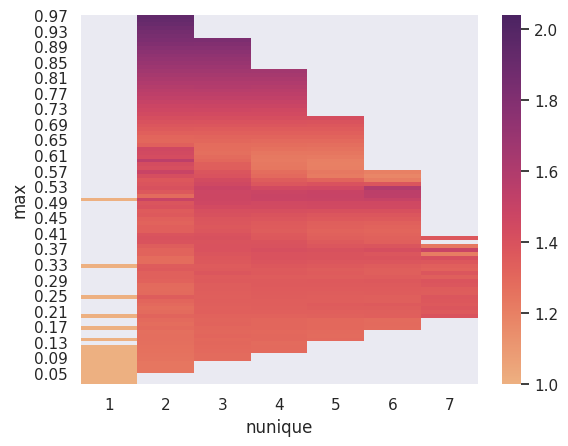

In [45]:
sns.heatmap(pt_mean.loc['RM'], cmap='flare', vmin=vmin, vmax=vmax)

<AxesSubplot: xlabel='nunique', ylabel='max'>

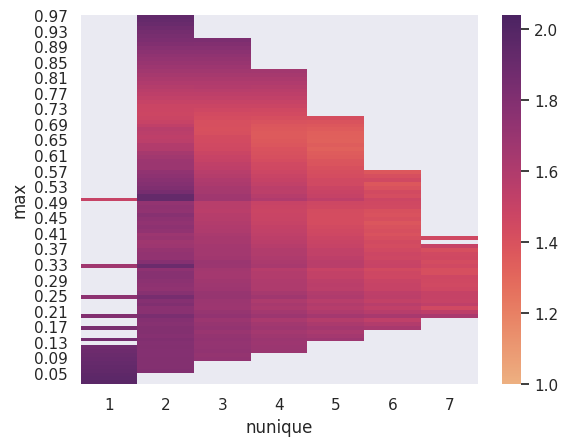

In [46]:
sns.heatmap(pt_mean.loc['DD'], cmap='flare', vmin=vmin, vmax=vmax)

## Cycles

histogram of (1) cycle start, (2) cycle length and (3) cycle end for every strategy

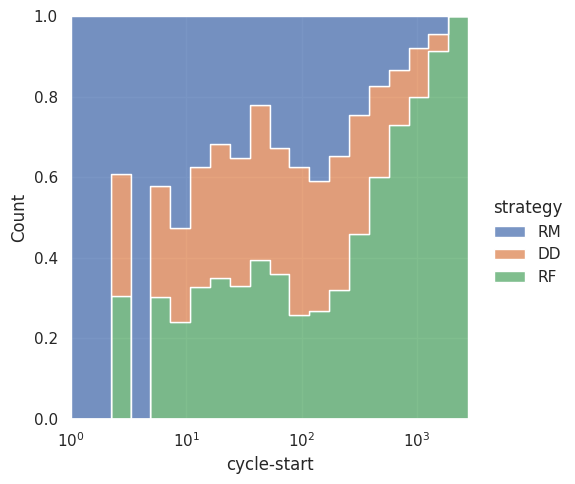

In [47]:
sns.displot(data=df_dr, x='cycle-start', hue='strategy', multiple='fill', element='step', log_scale=True, bins=20)

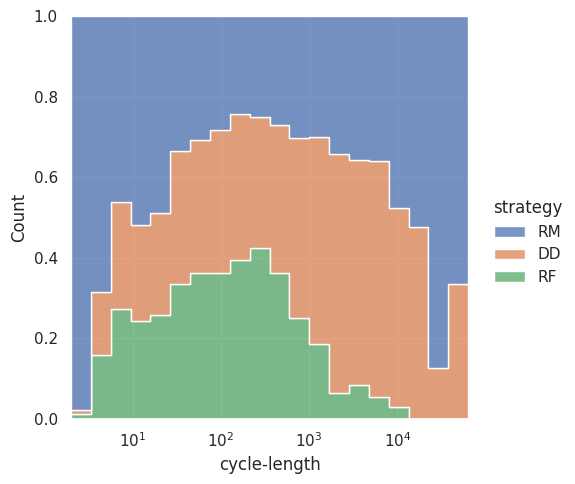

In [48]:
sns.displot(data=df_dr, x='cycle-length', hue='strategy', multiple='fill', element='step', log_scale=True, bins=20)

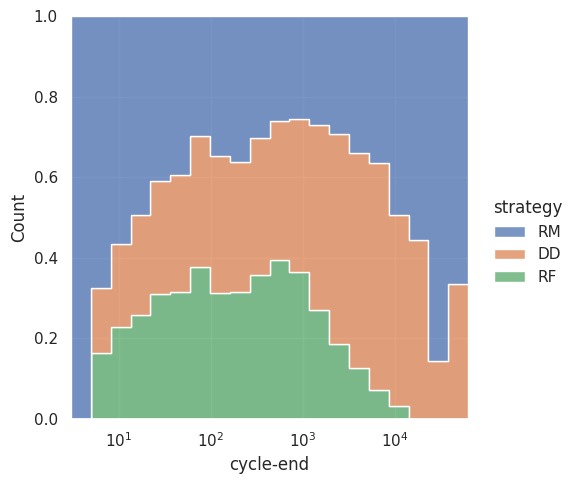

In [49]:
sns.displot(data=df_dr, x='cycle-end', hue='strategy', multiple='fill', element='step', log_scale=True, bins=20)

number of instances with early cycle starts

In [50]:
df_dr[df_dr['cycle-start'] < 6].value_counts(['strategy', 'cycle-start'], sort=False)

strategy  cycle-start
DD        3               65
          5              200
RF        3               65
          5              217
RM        1              192
          2              306
          3               84
          4              159
          5              286
dtype: int64

mean cycle start, length and end for every stratgy

In [51]:
df_dr.groupby('strategy')[['cycle-start','cycle-length','cycle-end']].mean()

,cycle-start,cycle-length,cycle-end
strategy,,,
DD,96.768349,207.951045,304.719394
RF,113.230221,124.541327,237.771548
RM,96.321933,152.197325,248.519258


letter-value plots showing the distribution of the (1) cycle start and (2) cycle length, depending on the rounded backlog (in steps of 0.1)

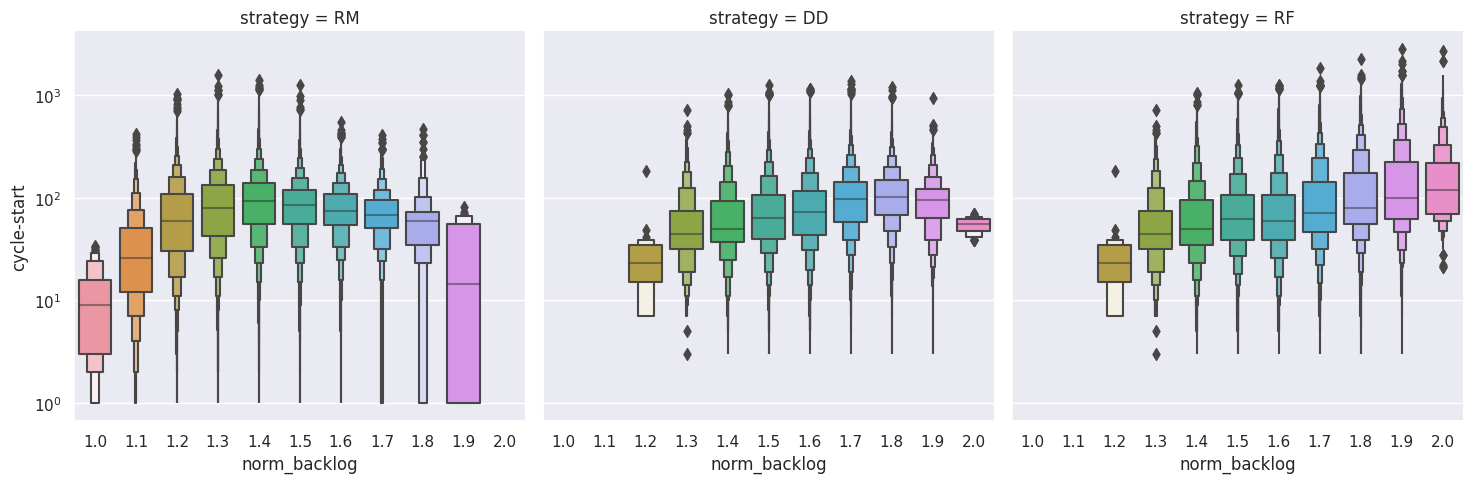

In [52]:
ax = sns.catplot(df_dr.round({'norm_backlog': 1}), x='norm_backlog', y='cycle-start', col='strategy', kind='boxen')
ax.set(yscale='log')

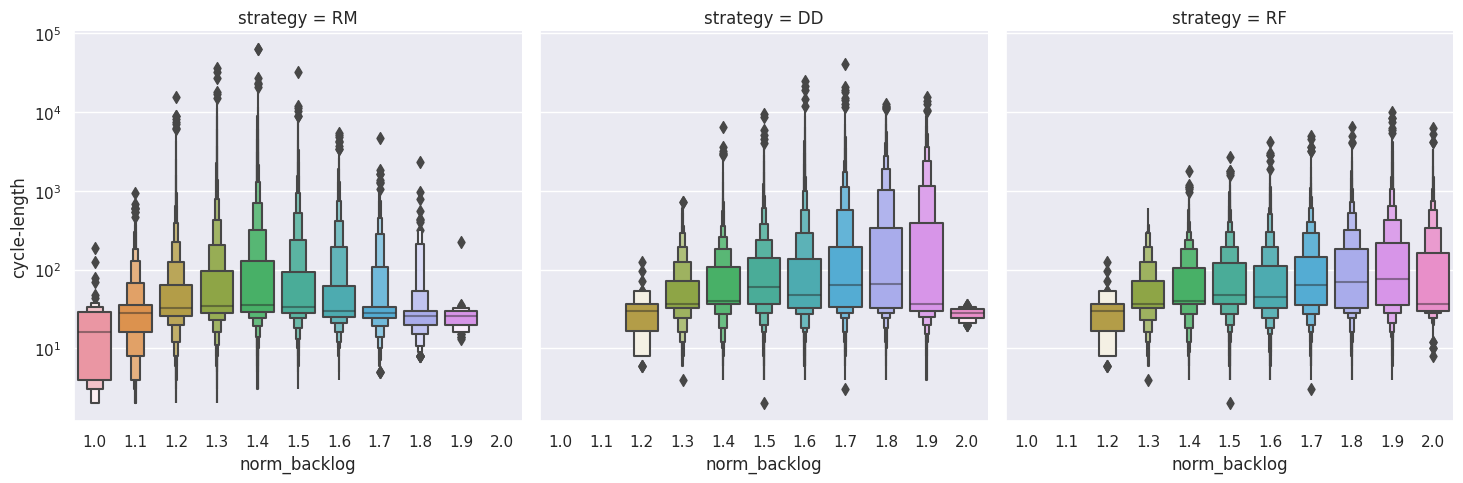

In [53]:
ax = sns.catplot(df_dr.round({'norm_backlog': 1}), x='norm_backlog', y='cycle-length', col='strategy', kind='boxen')
ax.set(yscale='log')

statistical information about previous plots

In [54]:
df_dr.round({'norm_backlog': 1}).groupby(['strategy', 'norm_backlog'])[['cycle-start', 'cycle-length']].describe()

cycle-start                                             \
                            count        mean         std   min   25%    50%   
strategy norm_backlog                                                          
DD       1.2                 34.0   28.823529   29.624387   7.0  15.0   23.0   
         1.3               1356.0   66.701327   64.843314   3.0  32.0   44.0   
         1.4              11764.0   78.097501   77.475218   3.0  37.0   50.0   
         1.5              21304.0   87.071254   81.759647   3.0  40.0   64.0   
         1.6              19206.0   95.649224   84.466377   3.0  43.0   72.0   
         1.7              14846.0  115.193992   90.759860   3.0  58.0   97.0   
         1.8               8725.0  120.028539   83.626238   3.0  68.0  102.0   
         1.9               2416.0  103.672599   64.909218   3.0  63.0   95.0   
         2.0                 55.0   53.727273    9.312386  39.0  47.0   55.0   
RF       1.2                 34.0   28.823529   29.624387   7.0  15.0   23.0   
         1.3               1271.0   67.108576   66.537438   3.0  32.0   44.0   
         1.4              10746.0   80.566071   84.532659   3.0  35.0   50.0   
         1.5              19088.0   90.344405   93.556824   3.0  39.0   62.0   
         1.6              15649.0   94.185827  106.221662   3.0  39.0   59.0   
         1.7              11294.0  118.676288  126.806606   3.0  46.0   71.0   
         1.8               8689.0  140.626885  152.894450   3.0  55.0   80.0   
         1.9               8182.0  179.621486  206.553567   3.0  62.0   99.0   
         2.0               4753.0  177.315801  168.257439  21.0  69.0  118.0   
RM       1.0                 93.0   11.075269    9.224538   1.0   3.0    9.0   
         1.1               2030.0   39.133005   43.166144   1.0  12.0   26.0   
         1.2              14483.0   80.948629   75.145383   1.0  30.0   60.0   
         1.3              22939.0  101.313658   87.725752   1.0  42.0   79.0   
         1.4              23384.0  109.370339   84.966751   1.0  56.0   93.0   
         1.5              11585.0   95.966163   67.028880   1.0  56.0   84.0   
         1.6               3961.0   86.264580   53.420853   1.0  54.0   75.0   
         1.7                940.0   76.520213   47.747635   1.0  51.0   68.0   
         1.8                237.0   68.413502   64.550252   1.0  35.0   60.0   
         1.9                 54.0   26.518519   28.215973   1.0   1.0   14.5   

                                      cycle-length                           \
                          75%     max        count        mean          std   
strategy norm_backlog                                                         
DD       1.2            35.00   182.0         34.0   31.705882    25.623769   
         1.3            74.25   715.0       1356.0   66.809735    82.907217   
         1.4            92.00  1028.0      11764.0   94.864842   153.966664   
         1.5           107.00  1236.0      21304.0  130.920531   251.003451   
         1.6           116.00  1133.0      19206.0  174.014995   523.152416   
         1.7           143.00  1375.0      14846.0  280.823521   785.420881   
         1.8           148.00  1194.0       8725.0  437.099484   994.163489   
         1.9           122.00   933.0       2416.0  518.094785  1246.591642   
         2.0            62.00    69.0         55.0   27.363636     4.656193   
RF       1.2            35.00   182.0         34.0   31.705882    25.623769   
         1.3            74.00   715.0       1271.0   64.833202    75.529880   
         1.4            94.00  1043.0      10746.0   85.316955    96.545621   
         1.5           107.00  1236.0      19088.0  101.225482   127.564063   
         1.6           107.00  1254.0      15649.0  104.186913   159.959721   
         1.7           143.00  1826.0      11294.0  132.712414   207.807398   
         1.8           172.00  2235.0       8689.0  158.257222   273.853391   
         1.9           221.75  2794.0   

letter-value plot showing (1) the cycle start and (2) the cycle length, categorized by the number of cups

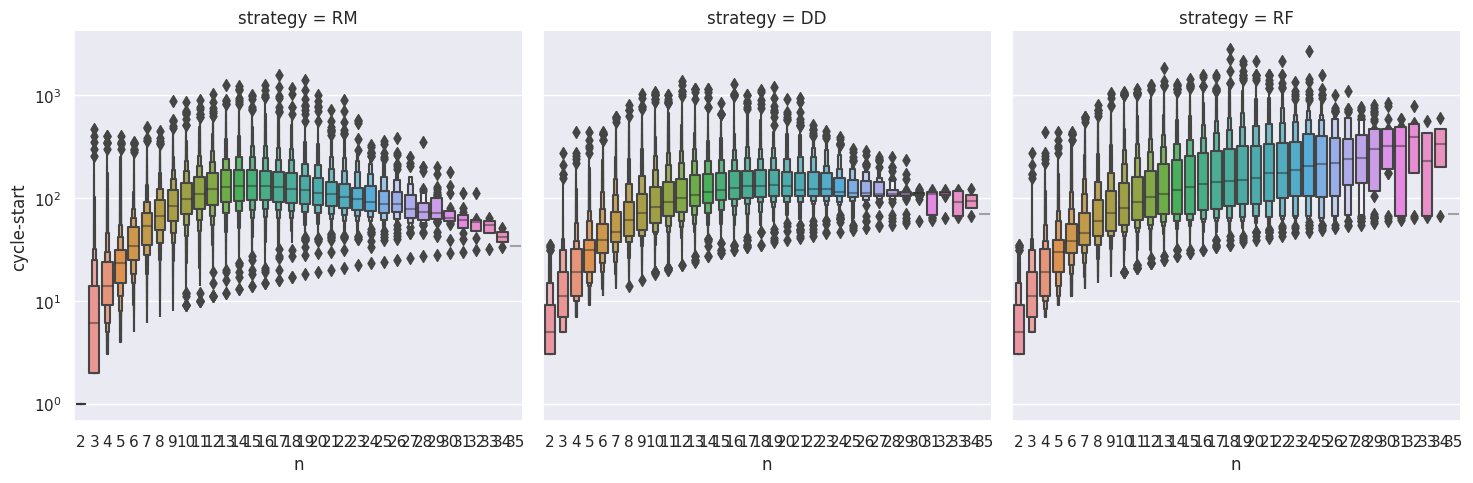

In [55]:
ax = sns.catplot(df_dr, x='n', y='cycle-start', col='strategy', kind='boxen')
ax.set(yscale='log')

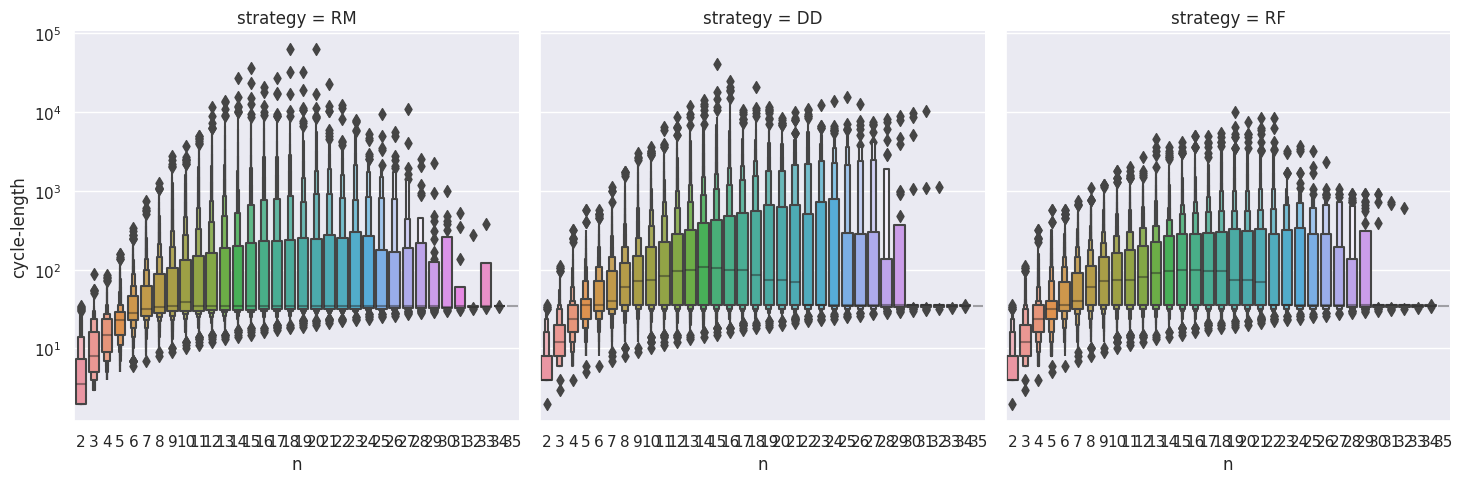

In [56]:
ax = sns.catplot(df_dr, x='n', y='cycle-length', col='strategy', kind='boxen')
ax.set(yscale='log')

statistical information describing the plots for `RM` above

In [57]:
df_dr[df_dr['strategy'] == 'RM'].groupby('n')[['cycle-start', 'cycle-length']].describe()

cycle-start                                                             \
         count        mean         std   min    25%    50%    75%     max   
n                                                                           
2        192.0    1.000000    0.000000   1.0   1.00    1.0    1.0     1.0   
3       1040.0   14.048077   31.479000   2.0   2.00    6.0   14.0   462.0   
4       2806.0   20.860656   29.038437   3.0   9.00   14.0   24.0   403.0   
5       5096.0   27.091837   23.859134   4.0  15.00   23.0   31.0   403.0   
6       7151.0   40.456999   25.673677   5.0  25.00   34.0   52.0   348.0   
7       8416.0   58.560599   33.962975   6.0  35.00   53.0   71.0   488.0   
8       8756.0   77.001142   42.591980   7.0  49.00   67.0   96.0   449.0   
9       8353.0   95.084760   53.584956   8.0  59.00   84.0  119.0   879.0   
10      7486.0  113.298557   66.440591   9.0  69.00   98.0  140.0   848.0   
11      6417.0  128.084931   76.089203  10.0  77.00  109.0  158.0   899.0   
12      5321.0  141.532983   85.207075  11.0  85.00  121.0  174.0  1014.0   
13      4309.0  152.300534   96.164065  12.0  91.00  128.0  186.0  1251.0   
14      3424.0  156.783002  103.085759  13.0  94.00  130.0  186.0  1234.0   
15      2684.0  157.110283   99.472442  14.0  95.00  131.0  186.0   993.0   
16      2078.0  157.524543  108.512586  15.0  95.00  130.0  181.0  1241.0   
17      1595.0  152.559248  106.534144  16.0  92.00  126.0  177.0  1578.0   
18      1212.0  149.017327  101.859315  17.0  89.75  122.0  173.0  1166.0   
19       915.0  141.257923  101.934490  18.0  86.50  118.0  163.0  1397.0   
20       684.0  136.350877   95.047447  19.0  85.00  111.0  155.0  1008.0   
21       508.0  127.535433   77.165392  20.0  83.00  108.0  143.0   714.0   
22       373.0  124.155496   84.984454  21.0  80.00  102.0  136.0   897.0   
23       272.0  116.422794   71.475808  22.0  75.75   96.5  125.0   568.0   
24       195.0  109.092308   53.060185  23.0  74.50   92.0  129.0   323.0   
25       139.0  103.474820   53.653927  24.0  71.00   88.0  116.0   357.0   
26        97.0  101.731959   52.334564  25.0  73.00   87.0  113.0   385.0   
27        67.0   91.791045   45.059401  26.0  64.00   77.0  105.5   247.0   
28        45.0   86.333333   53.754492  27.0  61.00   72.0   89.0   349.0   
29        30.0   82.500000   36.598238  28.0  62.00   71.5  100.0   201.0   
30        19.0   73.736842   33.891726  29.0  59.50   64.0   74.0   180.0   
31        12.0   62.000000   21.023796  30.0  51.00   61.0   68.5   112.0   
32         7.0   59.857143   25.621791  31.0  48.00   58.0   61.0   112.0   
33         4.0   51.000000   13.784049  32.0  45.50   54.5   60.0    63.0   
34         2.0   42.000000   12.727922  33.0  37.50   42.0   46.5    51.0   
35         1.0   34.000000         NaN  34.0  34.00   34.0   34.0    34.0   

   cycle-length                                                               
          count        mean          std   min    25%   50%     75%      max  
n                                                                             
2         192.0    6.692708     7.411915   2.0   2.00   3.5    7.25     35.0  
3        1040.0   11.531731     9.078364   3.0   5.00   8.0   16.00     89.0  
4        2806.0   16.986458    10.322906   4.0   9.00  15.0   24.00     85.0  
5        5096.0   25.142268    15.500330   5.0  15.00  23.0   29.00    160.0  
6        7151.0   37.992868    28.213979   6.0  23.00  28.0   46.00    336.0  
7        8416.0   54.701996    53.390685   7.0  26.00  32.0   63.00    744.0  
8        8756.0   75.258337    91.056063   8.0  28.00  34.0   88.00   1248.0  
9        8353.0   97.889501   148.961218   9.0  30.00  35.0  104.00   2760.0  
10       7486.0  133.014293   229.758046  10.0  30.00  39.0  132.00   3720.0  
11       6417.0  169.595294   360.226293  11.0  30.00  35.0  150.00   4980.0  
12       5321.0  213.380192   537.879706  12.0  31.00  35.0  164.00  11610.0  
13       4309.0  245.155489   675.914898  13.0 